# AMICI documentation example of the steady state solver logic

This is an example to document the internal logic of the steady state solver, which is used in preequilibration and postequilibration.

## Steady states of dynamical system

Not every dynamical system needs to run into a steady state. Instead, it may exhibit 
 * continuous growth, e.g., $$\dot{x} = x, \quad x_0 = 1$$
 * a finite-time blow up, e.g., $$\dot{x} = x^2, \quad x_0 = 1$$
 * oscillations, e.g., $$\ddot{x} = -x, \quad x_0 = 1$$
 * chaotic beviour, e.g., the Lorentz attractor
 
If the considered dynamical system has a steady state for positive times, then integrating the ODE long enough will bring equilibrate the system to this steady state. However, this may be computational more demanding than other approaches and may fail, if the maximum number of integration steps is exceeded before reaching the steady state.

In general, Newton's method will find the steady state faster than forward simulation. However, it only onvereges if started close enough to the steady state. Moreover, it will not work, if the dynamical system has conserved quantities which are not removed: conserved qunatities will cause singularities in the Jacobian of the right hand side of the system, such that the linear problem within each step of Newton's method can not be solved.

## Logic of the steady state solver

If AMICI has to equilibrate a dynamical system, it can do this either via simulating until the right hand side of the system becomes small, or it can try to find the steady state directly by Newton's method.
Amici decides automatically which approach is chosen and how forward or adjoint sensitivities are computed, if requested. However, the user can influence this behavior, if prior knowledge about the dynamical is available.

The logic which AMICI will follow to equilibrate the system works as follows:

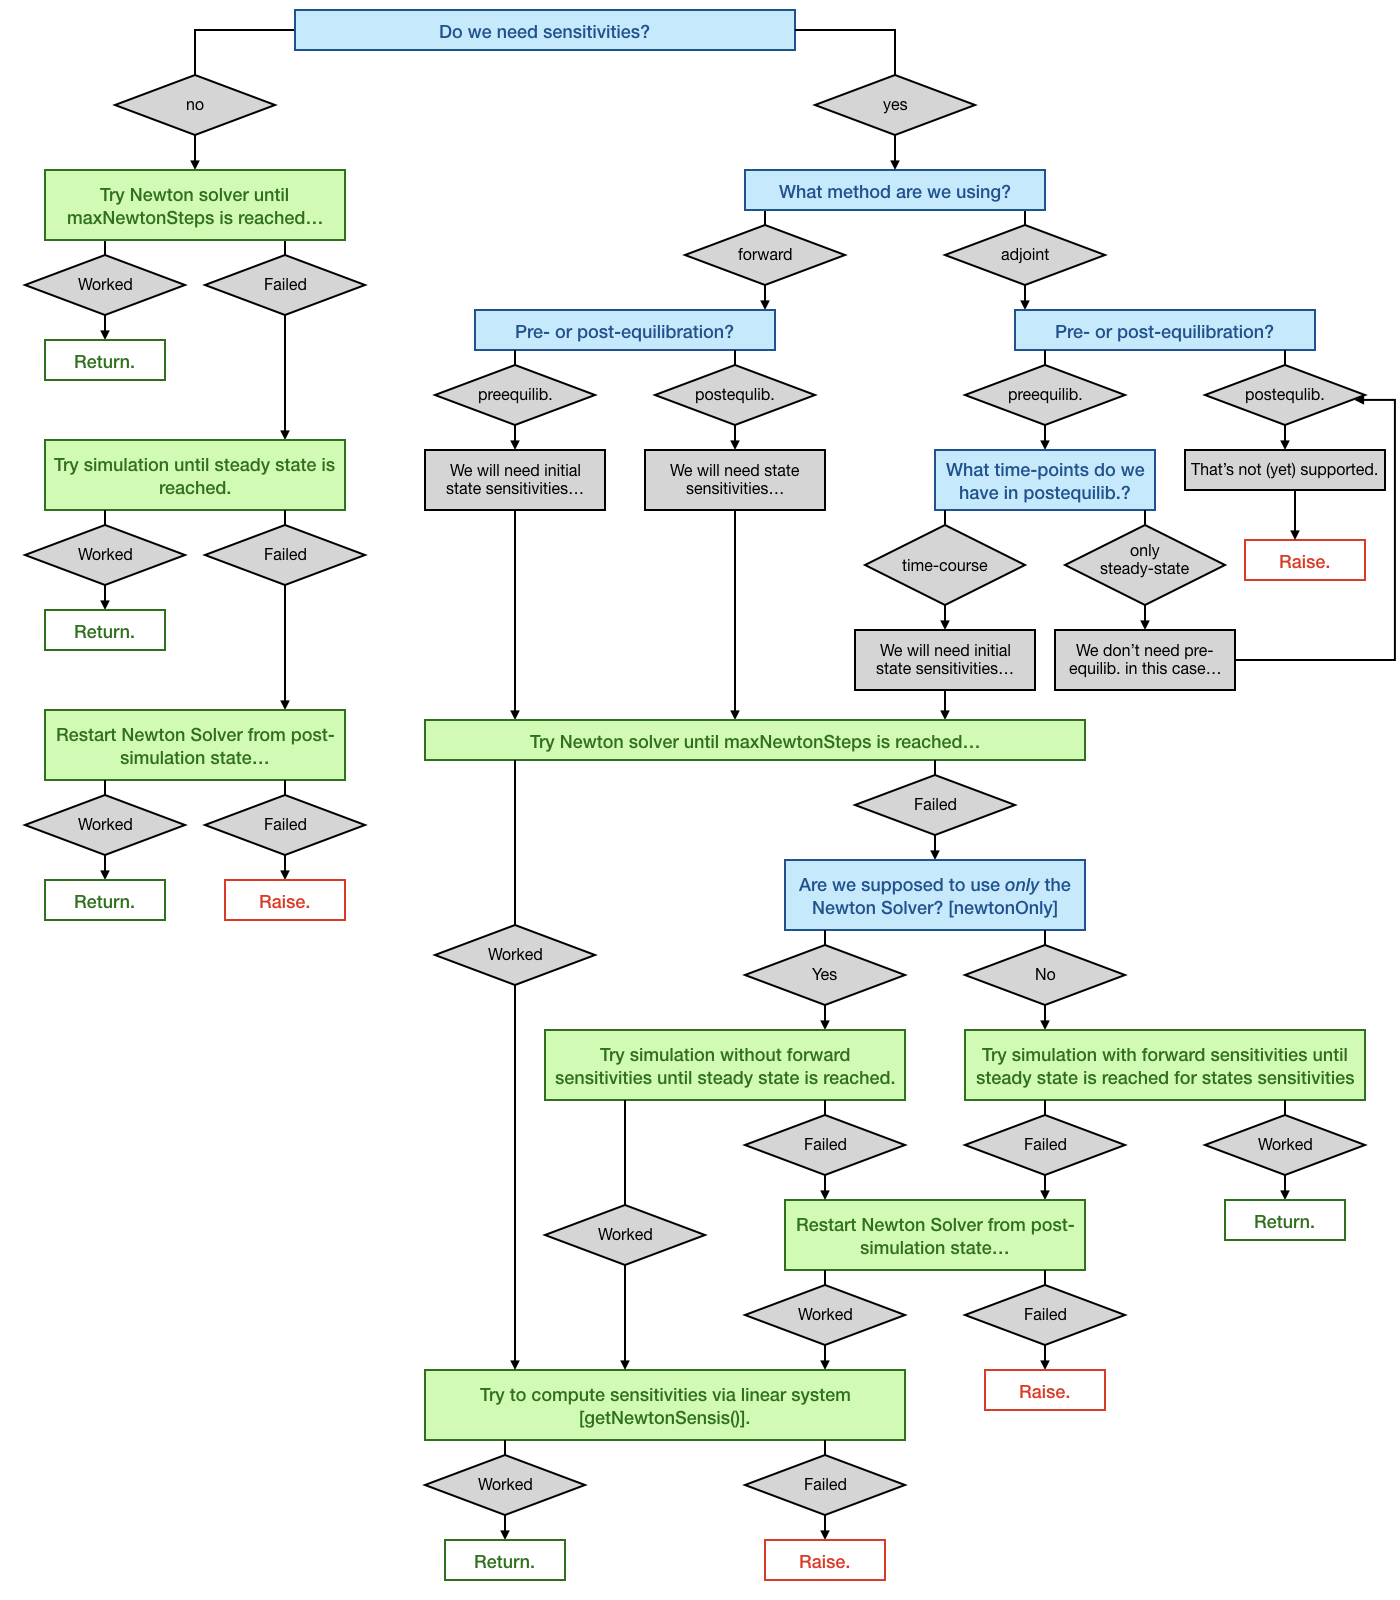

In [13]:
from IPython.display import Image
fig = Image(filename=('../../../documentation/gfx/steadystate_solver_workflow.png'))
fig

## The example model

We will use the [example model model_constant_species.xml], which has conserved species. Those are automatically removed in the SBML import of AMICI, but they can also be kept in the model to demonstrate the failure of Newton's method due to a singular right hand side Jacobian.

In [14]:
import libsbml
import importlib
import amici
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# SBML model we want to import
sbml_file = 'model_constant_species.xml'

# Name of the models that will also be the name of the python module
model_name = 'model_constant_species'
model_reduced_name = model_name + '_reduced'

# Directories to which the generated model code is written
model_output_dir = model_name
model_reduced_output_dir = model_reduced_name

# Read the model and give some output
sbml_reader = libsbml.SBMLReader()
sbml_doc = sbml_reader.readSBML(sbml_file)
sbml_model = sbml_doc.getModel()
dir(sbml_doc)

print('Species: ', [s.getId() for s in sbml_model.getListOfSpecies()])

print('\nReactions:')
for reaction in sbml_model.getListOfReactions():
    reactants = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfReactants()])
    products  = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfProducts()])
    reversible = '<' if reaction.getReversible() else ''
    print('%3s: %10s %1s->%10s\t\t[%s]' % (reaction.getId(), 
                        reactants,
                        reversible,
                        products,
                        libsbml.formulaToL3String(reaction.getKineticLaw().getMath())))



Species:  ['substrate', 'enzyme', 'complex', 'product']

Reactions:
creation:             -> substrate		[compartment * k_create]
binding:  substrate +  enzyme <->   complex		[compartment * (k_bind * substrate * enzyme - k_unbind * complex)]
conversion:    complex  -> enzyme +  product		[compartment * k_convert * complex]
decay:    product  ->          		[compartment * k_decay * product]


In [15]:
# Create an SbmlImporter instance for our SBML model
sbml_importer = amici.SbmlImporter(sbml_file)

# specify observables and constant parameters
constantParameters = ['init_substrate', 'init_enzyme']
observables = {
    'observable_product': {'name': '', 'formula': 'product'},
    'observable_substrate': {'name': '', 'formula': 'substrate'},
}
sigmas = {'observable_product': 1.0, 'observable_substrate': 1.0}

# import the model
sbml_importer.sbml2amici(model_reduced_name,
                         model_reduced_output_dir,
                         observables=observables,
                         constantParameters=constantParameters,
                         sigmas=sigmas)
sbml_importer.sbml2amici(model_name,
                         model_output_dir,
                         observables=observables,
                         constantParameters=constantParameters,
                         sigmas=sigmas,
                         compute_conservation_laws=False)

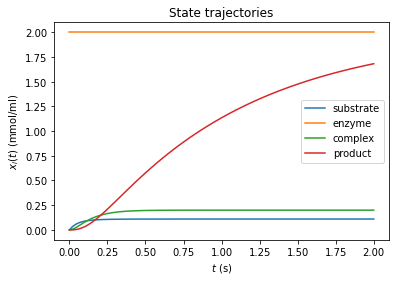

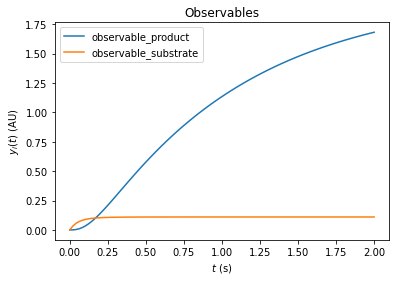

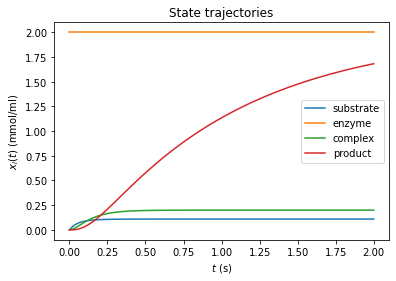

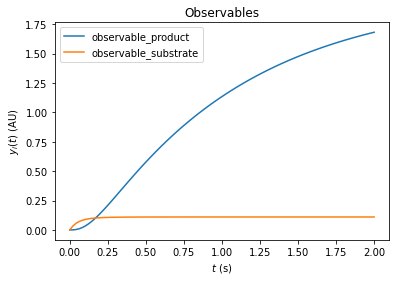

In [16]:
# import the models and run some test simulations
sys.path.insert(0, os.path.abspath(model_reduced_output_dir))
model_reduced_module = importlib.import_module(model_reduced_name)
model_reduced = model_reduced_module.getModel()

sys.path.insert(0, os.path.abspath(model_output_dir))
model_module = importlib.import_module(model_name)
model = model_module.getModel()


# simulate model with conservation laws
model_reduced.setTimepoints(np.linspace(0, 2, 100))
solver_reduced = model_reduced.getSolver()
rdata_reduced = amici.runAmiciSimulation(model_reduced, solver_reduced)

# simulate model without conservation laws
model.setTimepoints(np.linspace(0, 2, 100))
solver = model.getSolver()
rdata = amici.runAmiciSimulation(model, solver)

# plot trajectories
import amici.plotting
amici.plotting.plotStateTrajectories(rdata_reduced, model = model_reduced)
amici.plotting.plotObservableTrajectories(rdata_reduced, model = model_reduced)

amici.plotting.plotStateTrajectories(rdata, model = model)
amici.plotting.plotObservableTrajectories(rdata, model = model)

## Inferring the steady state of the system (postequilibration)

First, we want to demonstrate that Newton's method will fail with the unreduced model due to a singular right hand side Jacobian.

In [17]:
# Call postequilibration by setting an infinity timepoint
model.setTimepoints(np.full(1, np.inf))

# set the solver 
solver = model.getSolver()
solver.setNewtonMaxSteps(10)
solver.setMaxSteps(1000)
rdata = amici.runAmiciSimulation(model, solver)

#np.set_printoptions(threshold=8, edgeitems=2)
for key, value in rdata.items():
    print('%12s: ' % key, value)

          ts:  [inf]
           x:  [[0.11       2.         0.2        1.99999998]]
          x0:  [0. 2. 0. 0.]
        x_ss:  [nan nan nan nan]
          sx:  None
         sx0:  None
       sx_ss:  None
           y:  [[1.99999998 0.11      ]]
      sigmay:  [[1. 1.]]
          sy:  None
     ssigmay:  None
           z:  None
          rz:  None
      sigmaz:  None
          sz:  None
         srz:  None
     ssigmaz:  None
        sllh:  None
       s2llh:  None
           J:  [[-20.    0.   20.    0. ]
 [ -1.1   0.    1.1   0. ]
 [  1.    0.  -11.   10. ]
 [  0.    0.    0.   -1. ]]
        xdot:  [ 2.22044605e-16  0.00000000e+00 -2.22044605e-16  1.63307226e-08]
      status:  0.0
         llh:  nan
        chi2:  nan
         res:  [0. 0.]
        sres:  None
         FIM:  None
           w:  [[2.         2.         2.         1.99999998]]
  preeq_wrms:  nan
     preeq_t:  19.716480556780603
preeq_numlinsteps:  None
preeq_numsteps:  [[0 0 0]]
preeq_cpu_time:  0.0
 posteq_wrms: 

The field `posteq_numsteps` in rdata tells us how postequilibration worked:
 * the first entry informs us about the number of steps in Newton's method (here 0, as Newton's method did not work)
 * the second entry tells us, how many integration steps were taken until steady state was reached
 * the third entry informs us about the number of Newton steps in the second launch, after simulation

Here, only the second entry contains an integer, which is smaller than the maximum number of steps taken (<1000). Hence steady state was reached via simulation, which corresponds to the simulated time written to `preeq_time`.

We want to demonstrate a complete failure if inferring the steady state by reducing the number of integration steps to a lower value:

In [18]:
# reduce maxsteps for integration
solver.setMaxSteps(100)
rdata = amici.runAmiciSimulation(model, solver)

[Warning] AMICI:simulation: AMICI simulation failed:
Steady state computation failed to unsuccessful factorization of RHS Jacobian
Error occured in:
0          0x109cc7397 amici::SteadystateProblem::workSteadyStateProblem(amici::Solver*, amici::Model*, int) + 2615
1          0x109c76a1d amici::AmiciApplication::runAmiciSimulation(amici::Solver&, amici::ExpData const*, amici::Model&, bool) + 397
2          0x109c76884 amici::runAmiciSimulation(amici::Solver&, amici::ExpData const*, amici::Model&, bool) + 36
3          0x109c406a5 _wrap_runAmiciSimulation(_object*, _object*) + 549
4          0x104936309 cfunction_call_varargs + 320
5         


However, the same logic works, if we use the reduced model.
For sufficiently many Newton steps, postequilibration is achieved by Newton's method in the first run. In this specific example, the steady state is found within one step.

In [19]:
# Call postequilibration by setting an infinity timepoint
model_reduced.setTimepoints(np.full(1, np.inf))

# set the solver 
solver_reduced = model_reduced.getSolver()
solver_reduced.setNewtonMaxSteps(10)
solver_reduced.setMaxSteps(100)
rdata_reduced = amici.runAmiciSimulation(model_reduced, solver_reduced)

#np.set_printoptions(threshold=8, edgeitems=2)
for key, value in rdata_reduced.items():
    print('%12s: ' % key, value)

          ts:  [inf]
           x:  [[0.11 2.   0.2  2.  ]]
          x0:  [0. 2. 0. 0.]
        x_ss:  [nan nan nan nan]
          sx:  None
         sx0:  None
       sx_ss:  None
           y:  [[2.   0.11]]
      sigmay:  [[1. 1.]]
          sy:  None
     ssigmay:  None
           z:  None
          rz:  None
      sigmaz:  None
          sz:  None
         srz:  None
     ssigmaz:  None
        sllh:  None
       s2llh:  None
           J:  [[-20.  20.   0.]
 [  1. -11.  10.]
 [  0.   0.  -1.]]
        xdot:  [0. 0. 0.]
      status:  0.0
         llh:  nan
        chi2:  nan
         res:  [0. 0.]
        sres:  None
         FIM:  None
           w:  [[2. 2. 2. 2. 2.]]
  preeq_wrms:  nan
     preeq_t:  nan
preeq_numlinsteps:  None
preeq_numsteps:  [[0 0 0]]
preeq_cpu_time:  0.0
 posteq_wrms:  0.0
    posteq_t:  nan
posteq_numlinsteps:  None
posteq_numsteps:  [[1 0 0]]
posteq_cpu_time:  7.7e-05
    numsteps:  [0]
 numrhsevals:  [0]
numerrtestfails:  [0]
numnonlinsolvconvfails:  

## Postequilibration with sensitivities

Currently, postequilibration is only possible with forward sensitivities analysis. However, the possiblility to use adjoint sensitivity analysis will soon be implemented.

If forward sensitivity analysis is used, then state sensitivities at the timepoint `np.inf` will be computed. This can be done in (currently) two different ways:
 1. If the Jacobian $\nabla_x f$ of the right hand side $f$ is not (close to) singular, the most efficient approach will be solving the linear system of equation, which defines the steady state sensitivities:
 $$ 
 0 = \dot{s}^x = (\nabla_x f) s^x + \frac{\partial f}{\partial \theta} 
 \qquad \Rightarrow \qquad
 (\nabla_x f) s^x = - \frac{\partial f}{\partial \theta} 
 $$
 This approach will always be chosen by AMICI, if option `model.SteadyStateSensitivityMode` is set to `SteadyStateSensitivityMode.newtonOnly`. Furthermore, it will also be chosen if the steady state was found by Newton's method, as in this case, the Jacobian is at least not singular. A check for the condition number of the Jacobian is currently missing, but will soon be implemented.
 2. If the Jacobian is poorly conditioned or singular, then the only way to obtain a reliable result will be integrating the state variables with state sensitivities until the norm of the right hand side becomes small. This approach will be chosen by AMICI, if the steady state was found by simulation and the option `model.SteadyStateSensitivityMode` is set to `SteadyStateSensitivityMode.simulationFSA`. This apporach is numerically more stable, but the computation time for large models may be substantial.

Side remark:\
A possible third way may consist in a Robertson iteration type approach, which interprets the entries of the right hand side $f$ as residuals and minimizes the squared residuals $\Vert f \Vert^2$ by a Levenberg-Marquart algorithm. This appraoch would also work for poorly conditioned Jacobians (or could implement additional constraints as Lagrange multipliers) while being faster than a long forward simulation.

We want to demonstrate both possiblities to find the steady state sensitivities, as well as the failure of their computation if the JAcobian is singular and the `newtonOnly`setting was used.

In [31]:
# Call simulation with singular Jacobian and simulationFSA mode
model.setTimepoints(np.full(1, np.inf))
model.setSteadyStateSensitivityMode = amici.SteadyStateSensitivityMode.simulationFSA
solver = model.getSolver()
solver.setNewtonMaxSteps(10)
solver.setSensitivityMethod(amici.SensitivityMethod.forward)
solver.setSensitivityOrder(amici.SensitivityOrder.first)
solver.setMaxSteps(1000)
rdata = amici.runAmiciSimulation(model, solver)

for key, value in rdata_reduced.items():
    print('%12s: ' % key, value)

          ts:  [inf]
           x:  [[0.11 2.   0.2  2.  ]]
          x0:  [0. 2. 0. 0.]
        x_ss:  [nan nan nan nan]
          sx:  [[[-1.1e-02  0.0e+00 -0.0e+00 -0.0e+00]
  [ 1.0e-02  0.0e+00 -0.0e+00 -0.0e+00]
  [-1.0e-03  0.0e+00 -2.0e-02 -0.0e+00]
  [ 5.5e-02  0.0e+00  1.0e-01  1.0e+00]
  [-0.0e+00  0.0e+00 -0.0e+00 -2.0e+00]]]
         sx0:  [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
       sx_ss:  [[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
           y:  [[2.   0.11]]
      sigmay:  [[1. 1.]]
          sy:  [[[ 0.0e+00 -1.1e-02]
  [ 0.0e+00  1.0e-02]
  [ 0.0e+00 -1.0e-03]
  [ 1.0e+00  5.5e-02]
  [-2.0e+00  0.0e+00]]]
     ssigmay:  [[[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]]
           z:  None
          rz:  None
      sigmaz:  None
          sz:  None
         srz:  None
     ssigmaz:  None
        sllh:  [nan nan nan nan nan]
       s2llh:  None
           J:  [[-20.  20.   0.]
 

[Warning] AMICI:simulation: AMICI simulation failed:
Steady state sensitvitiy computation failed to unsuccessful factorization of RHS Jacobian
Error occured in:
0          0x109cc6d4c amici::SteadystateProblem::workSteadyStateProblem(amici::Solver*, amici::Model*, int) + 1004
1          0x109c76a1d amici::AmiciApplication::runAmiciSimulation(amici::Solver&, amici::ExpData const*, amici::Model&, bool) + 397
2          0x109c76884 amici::runAmiciSimulation(amici::Solver&, amici::ExpData const*, amici::Model&, bool) + 36
3          0x109c406a5 _wrap_runAmiciSimulation(_object*, _object*) + 549
4          0x104936309 cfunction_call_varargs + 320
5         


In [33]:
# Call simulation with singular Jacobian and newtonOnly mode (will fail)
model.setTimepoints(np.full(1, np.inf))
model.setSteadyStateSensitivityMode = amici.SteadyStateSensitivityMode.newtonOnly
solver = model.getSolver()
rdata = amici.runAmiciSimulation(model, solver)

for key, value in rdata.items():
    print('%12s: ' % key, value)

          ts:  [inf]
           x:  [[0.11       2.         0.2        1.99999998]]
          x0:  [0. 2. 0. 0.]
        x_ss:  [nan nan nan nan]
          sx:  None
         sx0:  None
       sx_ss:  None
           y:  [[1.99999998 0.11      ]]
      sigmay:  [[1. 1.]]
          sy:  None
     ssigmay:  None
           z:  None
          rz:  None
      sigmaz:  None
          sz:  None
         srz:  None
     ssigmaz:  None
        sllh:  None
       s2llh:  None
           J:  [[-20.    0.   20.    0. ]
 [ -1.1   0.    1.1   0. ]
 [  1.    0.  -11.   10. ]
 [  0.    0.    0.   -1. ]]
        xdot:  [ 2.22044605e-16  0.00000000e+00 -2.22044605e-16  1.63307226e-08]
      status:  0.0
         llh:  nan
        chi2:  nan
         res:  [0. 0.]
        sres:  None
         FIM:  None
           w:  [[2.         2.         2.         1.99999998]]
  preeq_wrms:  nan
     preeq_t:  19.716480556780603
preeq_numlinsteps:  None
preeq_numsteps:  [[0 0 0]]
preeq_cpu_time:  0.0
 posteq_wrms: 

In [27]:
# Call postequilibration by setting an infinity timepoint
model_reduced.setTimepoints(np.full(1, np.inf))
model_reduced.setSteadyStateSensitivityMode = amici.SteadyStateSensitivityMode.newtonOnly
solver_reduced = model_reduced.getSolver()
solver_reduced.setNewtonMaxSteps(10)
solver_reduced.setSensitivityMethod(amici.SensitivityMethod.forward)
solver_reduced.setSensitivityOrder(amici.SensitivityOrder.first)
solver_reduced.setMaxSteps(1000)
rdata_reduced = amici.runAmiciSimulation(model_reduced, solver_reduced)

for key, value in rdata_reduced.items():
    print('%12s: ' % key, value)

          ts:  [inf]
           x:  [[0.11 2.   0.2  2.  ]]
          x0:  [0. 2. 0. 0.]
        x_ss:  [nan nan nan nan]
          sx:  [[[-1.1e-02  0.0e+00 -0.0e+00 -0.0e+00]
  [ 1.0e-02  0.0e+00 -0.0e+00 -0.0e+00]
  [-1.0e-03  0.0e+00 -2.0e-02 -0.0e+00]
  [ 5.5e-02  0.0e+00  1.0e-01  1.0e+00]
  [-0.0e+00  0.0e+00 -0.0e+00 -2.0e+00]]]
         sx0:  [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
       sx_ss:  [[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
           y:  [[2.   0.11]]
      sigmay:  [[1. 1.]]
          sy:  [[[ 0.0e+00 -1.1e-02]
  [ 0.0e+00  1.0e-02]
  [ 0.0e+00 -1.0e-03]
  [ 1.0e+00  5.5e-02]
  [-2.0e+00  0.0e+00]]]
     ssigmay:  [[[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]]
           z:  None
          rz:  None
      sigmaz:  None
          sz:  None
         srz:  None
     ssigmaz:  None
        sllh:  [nan nan nan nan nan]
       s2llh:  None
           J:  [[-20.  20.   0.]
 

## Preequilibrating the model

Sometimes, we want to launch a solver run from a steady state which was inferred numerically, i.e., the system was preequilibrated. In order to do this with AMICI, we need to pass an ExpData object, which contains fixed parameter for the acutal simulation and for preequilibration of the model.

In [ ]:
# create edat, with 3 timepoints and 2 observables:
edata = amici.ExpData(2, 0, 0,
                      np.array([0., 0.1, 1.]))
edata.setObservedData([1.8] * 6)
edata.fixedParameters = np.array([3., 5.])
edata.fixedParametersPreequilibration = np.array([0., 2.])
edata.reinitializeFixedParameterInitialStates = True

In [ ]:
# create the solver object and run the simulation
solver_reduced = model_reduced.getSolver()
solver_reduced.setNewtonMaxSteps(10)
rdata_reduced = amici.runAmiciSimulation(model_reduced, solver_reduced, edata)

amici.plotting.plotStateTrajectories(rdata_reduced, model = model_reduced)
amici.plotting.plotObservableTrajectories(rdata_reduced, model = model_reduced)

In [ ]:
# we can also combine this with postequilibration.
edata.setTimepoints(np.array([0., 0.1, float('inf')]))

# run the simulation
rdata_reduced = amici.runAmiciSimulation(model_reduced, solver_reduced, edata)

## Prequilibration with sensitivities

T.B.D.